

---


**Assignment - Week 4**


---



*Christopher Mena - CAI2840C*





---


**IMPORTS**


---



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip



---


**Part 1: Video I/O Application**


---

We (I) read each frame, and applied simple transformations, and write the processed frames to a new output video. We used cv2.VideoCapture(), and each frame was given an overlay text and a timestamp.  These new frames were written using cv2.VideoWriter().

In [10]:

# Input video
input_video = '/content/Ball Rolling.mp4'
cap = cv2.VideoCapture(input_video)

# Video Properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = '/content/Ball_Rolling_Output.mp4'
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Processing frames
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Calculate timestamp in secs
    timestamp = frame_count / fps
    frame_count += 1

    # Overlay "MDC" text on each frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    position_mdc = (50, 50)
    font_scale = 1
    font_color_mdc = (255, 0, 0)  # Blue text
    thickness = 2
    cv2.putText(frame, "MDC", position_mdc, font, font_scale, font_color_mdc, thickness, cv2.LINE_AA)

    # Overlay timestamp
    position_time = (50, 100)  # Position below "MDC"
    font_color_time = (0, 255, 255)  # Yellow text
    cv2.putText(frame, f"Time: {timestamp:.2f}s", position_time, font, font_scale, font_color_time, thickness, cv2.LINE_AA)

    # Writing the Video
    out.write(frame)

# Release resources
cap.release()
out.release()

# Display output video
clip = VideoFileClip(output_video)
clip.ipython_display(width=600)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4




---


**Part 2: Motion Detection Application with Foreground Mass and Erosion**


---


Motion detection was achieved by creating a foreground mask. This calculates the difference between the existing frame and the background.  Erosion was also applied to help reduce noise. These methods help detect the changes in light intensity as the ball rolls... thus achieving motion detection of the ball.


In [16]:
input_video = '/content/Ball Rolling.mp4'
video_cap = cv2.VideoCapture(input_video)

frame_w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

size = (frame_w, frame_h)
# Original size after concatenation.
# size_quad = (int(2*frame_w), int(2*frame_h))
# Half the original size.
size_quad = (int(frame_w), int(frame_h))

video_out_ball = cv2.VideoWriter('video_out_ball.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size_quad)

def drawBannerText(frame, text, banner_height_percent = 0.08, font_scale = 0.8, text_color = (0, 255, 0),
                   font_thickness = 2):
    # Draw a black filled banner across the top of the image frame.
    # percent: set the banner height as a percentage of the frame height.
    banner_height = int(banner_height_percent * frame.shape[0])
    cv2.rectangle(frame, (0, 0), (frame.shape[1], banner_height), (0, 0, 0), thickness = -1)

    # Draw text on banner.
    left_offset = 20
    location = (left_offset, int(10 + (banner_height_percent * frame.shape[0]) / 2))
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color,
                font_thickness, cv2.LINE_AA)

bg_sub = cv2.createBackgroundSubtractorKNN(history = 400)

ksize = (5, 5)
red = (0, 0, 255)
yellow = (0, 255, 255)

# Quad view that will be built.
#------------------------------------
# frame_fg_mask       :  frame
# frame_fg_mask_erode :  frame_erode
#------------------------------------

while True:
    ret, frame = video_cap.read()

    if frame is None:
        break
    else:
        frame_erode = frame.copy()

    # Stage 1: Motion area based on foreground mask.
    fg_mask = bg_sub.apply(frame)
    motion_area = cv2.findNonZero(fg_mask)
    x, y, w, h = cv2.boundingRect(motion_area)

    # Stage 2: Motion area based on foreground mask (with erosion)
    fg_mask_erode = cv2.erode(fg_mask, np.ones(ksize, np.uint8))
    motion_area_erode = cv2.findNonZero(fg_mask_erode)
    xe, ye, we, he = cv2.boundingRect(motion_area_erode)

    # Draw bounding box for motion area based on foreground mask
    if motion_area is not None:
        cv2.rectangle(frame, (x, y), (x + w, y + h), red, thickness = 6)

    # Draw bounding box for motion area based on foreground mask (with erosion)
    if motion_area_erode is not None:
        cv2.rectangle(frame_erode, (xe, ye), (xe + we, ye + he), red, thickness = 6)

    # Convert foreground masks to color so we can build a composite video with color annotations.
    frame_fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
    frame_fg_mask_erode= cv2.cvtColor(fg_mask_erode, cv2.COLOR_GRAY2BGR)

    # Annotate each video frame.
    drawBannerText(frame_fg_mask, 'Foreground Mask')
    drawBannerText(frame_fg_mask_erode, 'Foreground Mask Eroded')

    # Build quad view.
    frame_top = np.hstack([frame_fg_mask, frame])
    frame_bot = np.hstack([frame_fg_mask_erode, frame_erode])
    frame_composite = np.vstack([frame_top, frame_bot])

    # Create composite video with intermediate results (quad grid).
    fc_h, fc_w, _= frame_composite.shape
    cv2.line(frame_composite, (0, int(fc_h/2)), (fc_w, int(fc_h/2)), yellow, thickness=1, lineType=cv2.LINE_AA)

    # The resulting frame is in 2k resolution. Colab might fail to load large frames, hence resizing to half.
    # You may comment the following line in local environment.
    frame_composite = cv2.resize(frame_composite, None, fx=0.5, fy=0.5)

    # Write video files.
    video_out_ball.write(frame_composite)

video_cap.release()
video_out_ball.release()


input_video2 = './video_out_ball.mp4'

# loading output video
clip = VideoFileClip(input_video2)
clip.ipython_display(width = 1000)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  87%|████████▋ | 109/126 [00:00<00:00, 280.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video_out_ball.mp4, 691200 bytes wanted but 0 bytes read,at frame 125/126, at time 4.17/4.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4




---

**Part 3: Contour Detection Application**


---
Countour detection was applied to an image containing simple geometric shapes.  We converted the image to grayscale, and then applied a binary threshold. This allowed us to detect the countours of the shapes, specifically with cv2.findCountours().   


Text(0.5, 1.0, 'Grayscale Image of Simple Geometric Shapes')

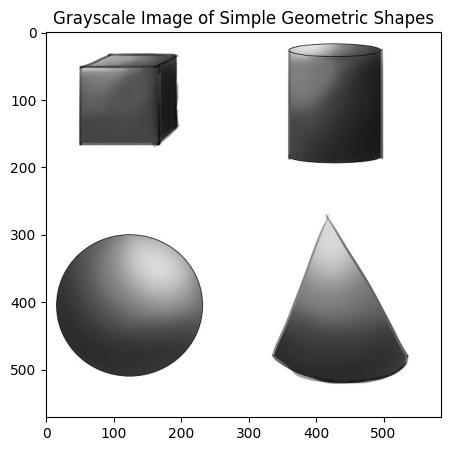

In [38]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
matplotlib.rcParams['image.cmap'] = 'gray'


imagePath = '/content/simplegeometricshapes.jpg'
image = cv2.imread(imagePath)

# Convert to grayscale
imageGray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


# Display images
plt.imshow(imageGray);
plt.title('Grayscale Image of Simple Geometric Shapes')



Text(0.5, 1.0, 'Binary Threshold')

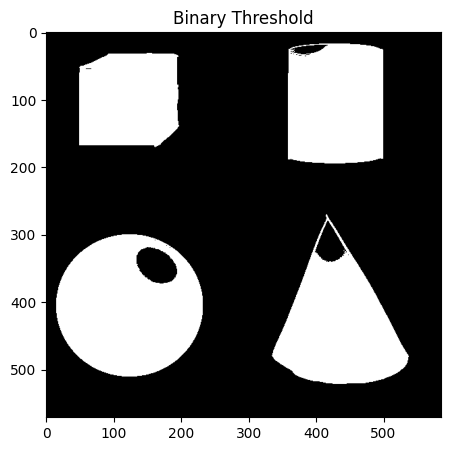

In [42]:
ret, thresh = cv2.threshold(imageGray, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh);
plt.title('Binary Threshold')

Text(0.5, 1.0, 'Countour detection')

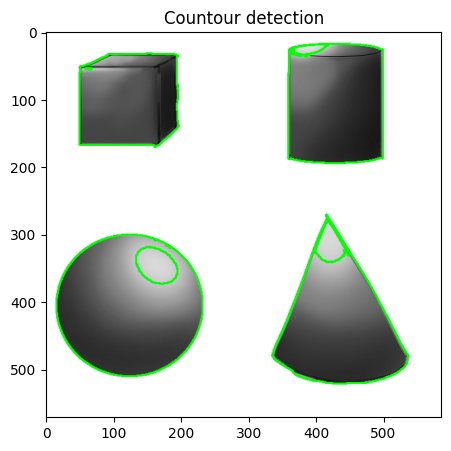

In [41]:
# Find contours in the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw the contours on
contour_image = image.copy()

# Draw all contours on the image (in green)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness 2

# Display the image with contours
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for matplotlib
plt.title('Countour detection')
